# Introduction

Coal Quality Inspection — End-to-End Vision Pipeline (YOLO Detection + MobileNetV2 Classification + Flask API)
## English
This project reconstructs a full production-grade coal-quality inspection system originally deployed in a mining environment. Because the real project is under NDA, all experiments here are reproduced using publicly available coal imagery datasets—but the engineering design, modeling steps, and reasoning strictly follow the real pipeline.

The goal is straightforward: **automate the entire process of detecting coal on conveyor belts and estimating its quality in real time**, replacing inconsistent human inspection with a fast, stable, and reproducible computer-vision workflow.

Coal images captured in mines suffer from extreme variability:
- underground images are often very dark  
- conveyor-belt images are sometimes overexposed  
- dust on lenses, vibration, and shadows introduce noise  
- lighting changes constantly across shifts and mining zones  

To address these challenges, the system is designed as a **two-stage vision pipeline**:

### **1. YOLO (v5 + v8) for coal-region detection**  
We first train YOLO models to locate all coal/gangue regions on each conveyor-belt image.  
This step transforms a complex full-image problem into clean ROIs (Regions of Interest), enabling robust downstream classification.  
Both YOLOv5 and YOLOv8 versions are included:
- VOC → YOLO label conversion  
- train/val/test dataset construction  
- lightweight, high-speed YOLOxN models for real-time usage  

### **2. MobileNetV2 for coal-quality classification**  
Once ROIs are extracted, each crop is classified into four coal-quality levels using a MobileNetV2-based model.  
Because quality is mainly a fine-grained texture task, extensive preprocessing and controlled experiments were necessary:
- CLAHE normalization for uneven lighting  
- edge-enhanced variants for ablation  
- backbone comparison under 100-sample stress tests  
- freeze vs. finetune transfer-learning analysis  
- scaling from 100 → 500 → 5000 samples to evaluate robustness  

Across all experiments, **MobileNetV2 (frozen feature extractor)** consistently provided the best balance of accuracy, stability, and deployment latency.

### **3. Flask API for real-time inference**  
Finally, the YOLO detector and MobileNetV2 classifier are connected into a single stateless REST service:
- `POST /predict` accepts an image  
- YOLO detects all coal regions  
- each ROI is classified by MobileNetV2  
- results are aggregated into a structured JSON response  
- outputs include box locations, per-ROI quality, and overall coal-quality distribution  

Model weights are loaded once at startup, keeping inference responsive (<1s) on a small EC2 instance or edge server.

---

## 中文
本项目完整复现了一个在真实矿场环境中部署过的**煤质智能检测系统**。  
由于原始项目受 NDA 限制，这里使用公共数据集重新跑完整流程，但所有的建模逻辑、工程设计、对比实验和推理架构都与真实生产版本一致。

系统的核心目标是：  
**自动化识别传送带上的煤块，并实时判断煤质等级，替代人工检测的主观性与不稳定性。**

矿区图像具有大量噪声与光照问题：
- 井下环境极暗  
- 皮带区域有时严重过曝  
- 镜头常被灰尘覆盖  
- 机械阴影频繁出现  
- 光照随班次和区域剧烈变化  

为解决上述难题，我们将任务拆成一个 **双阶段视觉系统**：

### **1. YOLO（v5 + v8）进行煤块区域检测**  
首先训练 YOLO 检测模型，定位每张图中的煤/矸石区域。  
这一步的作用是把复杂的整图问题转化成干净的 ROI 裁剪任务，为分类器提供稳定输入。  
本项目同时提供 YOLOv5 与 YOLOv8 的训练流程：
- VOC → YOLO 标签转换  
- 构建 train/val/test 标准数据集  
- 使用 nano/small 模型支持实时部署  

### **2. MobileNetV2 进行煤质分类**  
检测出的 ROI 会被送入 MobileNetV2 分类网络，判断煤块属于四种质量等级。  
由于煤质判断高度依赖**细粒度纹理特征**，我们进行了大量对照实验：
- CLAHE 光照归一化  
- 边缘增强的结构消融  
- 100 张小样本下的 Backbone 压测  
- freeze vs finetune 的迁移学习策略对比  
- 100 → 500 → 5000 数据规模下的全链路性能评估  

最终，**冻结特征层的 MobileNetV2** 在稳定性、推理速度、模型体积与准确率之间达成了最佳平衡。

### **3. Flask API 实现端到端实时推理服务**  
最终将 YOLO + MobileNetV2 封装为一个无状态的 REST 服务：
- `POST /predict` 传入图片  
- YOLO 检测煤块位置  
- 对每个 ROI 做 MobileNetV2 分类  
- 聚合成结构化 JSON 输出  
- 包含每个框的预测结果与整图的总体煤质分布  

模型在服务启动时一次性加载，推理过程保持轻量，延迟通常在 1 秒以内，非常适合 EC2 或边缘设备部署。




# Data Preprocessing

## Lighting Standardization & CLAHE Preprocessing
During data acquisition, we standardized lighting using a 24‑strip LED system (8 W per strip) to maintain 1200 ± 100 Lux, and captured images with a Basler acA4096‑40gc industrial camera at 4096×2168 resolution and 42 fps. Despite these controls, future deployment scenarios may encounter uneven lighting. Consequently, to enhance the model’s robustness and generalization, we apply CLAHE to all collected images, equalizing local contrast and mitigating illumination variation.

Parameter Selection for CLAHE


*   clipLimit controls the maximum amount of contrast enhancement in each local region. The default value in OpenCV is 40, but this is often too aggressive and may lead to inconsistent detail enhancement. A value between 2.0 and 5.0 is typically preferred, as it improves local contrast while avoiding excessive sharpening and noise amplification.
*   tileGridSize defines how the image is divided into smaller tiles. Each tile is processed individually using histogram equalization, and the results are blended with bilinear interpolation to ensure smooth transitions. A grid size of (8, 8) is the default and provides a good balance: it enhances local details without producing visible block artifacts




.

# 1. Coal Image Classification Pipeline — Section Overview  
## English  

This section documents the complete coal-quality classification pipeline that we originally engineered and deployed in a real mining production environment. Due to NDA constraints, the version presented here is a fully aligned reconstruction using a large public dataset (e.g., DsCGF ~270k raw coal images). All preprocessing steps, model comparison logic, and engineering decisions strictly follow the real production pipeline, ensuring that the relative outcomes remain valid even though the absolute performance metrics differ.

Coal quality inspection in mining operations is traditionally manual and highly subjective. Different inspectors may apply different quality standards, and lighting varies dramatically across tunnels and conveyor belts. These inconsistencies motivated us to build a fully automated, reproducible, and explainable classification system that could operate reliably under real-world constraints.

We formulate the task as a **4-class supervised learning problem**:

- **High-quality coal** — >80% coal surface area  
- **Acceptable-quality coal** — 60–80%  
- **Poor-quality coal** — <60%  
- **Background / non-coal regions**

From an engineering perspective, the pipeline must solve four challenges simultaneously:

1. **Lighting variability**  
   Coal images may be too dark (underground) or overexposed (belt surface). CNNs trained naïvely on such data tend to overfit lighting instead of material texture. This motivates CLAHE and other normalization strategies.

2. **Texture-driven classification**  
   Coal quality is fundamentally a texture problem—fine-grained, subtle differences in surface roughness and fragment density. The model must capture these patterns robustly, even under uneven illumination.

3. **Data scarcity vs model capacity**  
   Real mining environments rarely offer perfectly labeled thousands-of-samples datasets at the beginning. This requires careful evaluation of freeze vs finetune strategies, especially under <500-image conditions.

4. **Deployment constraints**  
   The final model must run in real-time in a resource-constrained environment (edge servers / low-power EC2 instances). This imposes strict latency and memory constraints, naturally pushing us toward lightweight architectures like MobileNetV2.

Across the next subsections, we progressively move through the full engineering pipeline:

- **Data Normalization (CLAHE, Edge Extraction)**  
- **Backbone Benchmarking on Small-scale Data (100 samples)**  
- **Transfer-learning Strategies under Scarcity (Freeze vs Finetune)**  
- **Scaling Up Experiments (500 → 5000 samples)**  
- **Final Model Selection for Production (MobileNetV2_freeze)**  

This structure mirrors how real teams make decisions: start with robustness, test hypotheses under low-resource conditions, verify scaling behavior, then pick a model that balances accuracy, latency, stability, and deployment cost.

---

## 中文  

本节记录的是我们在真实矿场生产环境中设计并部署过的 **煤质智能识别管线（Coal Quality Classification Pipeline）**。  
由于受到 NDA 限制，这里展示的版本基于公开数据集（如 DsCGF，约 27 万张煤炭图像）进行了完整复现，但所有的 **预处理步骤、模型比较逻辑、工程化决策** 都与真实系统保持一致，从而确保“相对结论”完全有效。

传统的煤质检验依赖人工，主观性极强，检验员之间容易出现标准不一致的问题；同时矿区光照极不稳定，井下环境昏暗、传送带区域又可能过曝。所有这些因素都驱动我们构建一个 **标准化、可复现、可解释、可大规模部署的智能识别系统**。

在复现设计中，我们将任务定义为一个 **四分类监督学习问题**：

- **高品质煤** — 表面积 > 80%  
- **中等品质煤** — 60–80%  
- **低品质煤** — < 60%  
- **背景 / 非煤区域**

从工程角度看，这套系统需要同时解决四个核心难题：

1. **光照变化巨大**  
   煤矿图像极易过暗或过亮，未经处理直接训练 CNN 会导致模型学习到“光照”，而非“材质纹理”。这促使我们采用 CLAHE 等归一化方法。

2. **基于纹理的细粒度分类**  
   煤质本质上是一个纹理问题——差异微小但关键，需要模型在噪声、光照变化下仍能保持稳健。

3. **数据稀缺与模型容量的平衡**  
   矿场开始部署时，通常不可能立刻拿到成千上万张带精确标注的数据。因此我们必须谨慎比较 freeze 与 finetune 策略，尤其是在 100–500 样本规模下。

4. **部署侧约束（延迟 / 内存 / 并发）**  
   最终模型需要在资源受限的设备上运行（边缘服务器、或低配 EC2 实例）。这使得轻量模型（如 MobileNetV2）成为更合理的选择。

接下来的小节将逐步展示整个工程流水线：

- **数据归一化（CLAHE、边缘提取）**  
- **小样本条件下的 Backbone Benchmark（100 张）**  
- **迁移学习策略对比（Freeze vs Finetune）**  
- **扩大数据规模后的表现（500 → 5000）**  
- **最终模型选择（MobileNetV2_freeze 作为生产模型）**

这套结构与真实工程团队的决策逻辑完全一致：  
先保证鲁棒性 → 再在低资源条件下检验假设 → 再验证扩展能力 → 最终选择“精度 + 速度 + 稳定性 + 成本”最优解。



## 1.1 Preprocessing Pipeline（CLAHE + Edge）
## English
This part of the pipeline corresponds to two Colab cells:  
one generates the CLAHE-normalized dataset, and the other optionally extracts edges from those CLAHE images.  
They work together because both steps serve the same purpose: **make the dataset more stable before we test any backbone**.

The CLAHE cell normalizes uneven lighting—something that happens constantly in mining environments. By enhancing only the L-channel in LAB space, the images maintain consistent texture contrast without artificial color distortion.

The second cell builds an edge-based variant. It’s not meant to improve accuracy directly but to give us a different “structural perspective” of the same data. Running the same models on both versions helps us understand which backbones rely heavily on fine texture vs higher-level structure.

Together, these two preprocessing steps give us controlled input conditions, making later benchmarking interpretable instead of noisy guesswork.

## 中文
这一部分对应两个 Colab cell：  
一个用于生成 CLAHE 光照归一化数据集，另一个在 CLAHE 基础上提取边缘。  
把这两个步骤放在一起，是因为它们都属于 **数据稳定化的预处理流程**，在任何模型训练之前必须先做好。

CLAHE 用于解决矿区图像最常见的光照不均问题。通过增强 LAB 空间中的亮度通道，纹理信息更清晰，同时不会引入颜色偏差。

第二个 cell 会在 CLAHE 图像上提取边缘。它的目的不是提升准确率，而是提供一种“结构视角”。同样的模型在两套数据上的表现差异，能帮助我们判断模型到底依赖纹理还是轮廓结构。

有了这两套预处理数据，我们后续的模型对比就更可靠，不会因为光照或噪声干扰导致错误结论。



In [ ]:
# 第一步：导入库 & 挂载 Drive
import os, cv2
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

# CLAHE 增强函数
def apply_clahe(img_path, clip_limit=2.0, grid_size=(8,8)):
    img = cv2.imread(img_path)
    if img is None:
        return None
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return final

# 要处理的子集列表
base_src = "/content/drive/MyDrive/coal/image_classification"
base_dst = "/content/drive/MyDrive/coal/image_classification_Clahe"  # 可根据需要更改输出目录

subsets = ["train_100", "train_500", "val", "test"]

for subset in subsets:
    src_dir = os.path.join(base_src, subset)
    dst_dir = os.path.join(base_dst, subset + "_Clahe")
    os.makedirs(dst_dir, exist_ok=True)
    print(f"\nProcessing subset: {subset} → {dst_dir}")
    for class_name in os.listdir(src_dir):
        src_class = os.path.join(src_dir, class_name)
        dst_class = os.path.join(dst_dir, class_name)
        os.makedirs(dst_class, exist_ok=True)
        for fname in tqdm(os.listdir(src_class), desc=f"{subset}/{class_name}", leave=False):
            src_path = os.path.join(src_class, fname)
            dst_path = os.path.join(dst_class, fname)
            try:
                enhanced = apply_clahe(src_path, clip_limit=2.0, grid_size=(8,8))
                if enhanced is not None:
                    cv2.imwrite(dst_path, enhanced)
            except Exception as e:
                # 可根据需要打印 e
                continue

print("\n✅ All subsets processed and CLAHE images saved.")


Mounted at /content/drive

Processing subset: train_100 → /content/drive/MyDrive/coal/image_classification_Clahe/train_100_Clahe



Processing subset: train_500 → /content/drive/MyDrive/coal/image_classification_Clahe/train_500_Clahe



Processing subset: val → /content/drive/MyDrive/coal/image_classification_Clahe/val_Clahe



Processing subset: test → /content/drive/MyDrive/coal/image_classification_Clahe/test_Clahe



✅ All subsets processed and CLAHE images saved.


In [ ]:
import os, cv2
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

def apply_canny_on_clahe(img_path, t_lower=50, t_upper=150):
    img = cv2.imread(img_path)
    if img is None: return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 1.4)
    edges = cv2.Canny(blurred, threshold1=t_lower, threshold2=t_upper)
    return cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

base_clahe = "/content/drive/MyDrive/coal/image_classification_Clahe"
base_edge = "/content/drive/MyDrive/coal/image_classification_Clahe_Edge"
subsets = ["train_100", "train_500", "val", "test"]

for subset in subsets:
    src_dir = os.path.join(base_clahe, subset + "_Clahe")
    dst_dir = os.path.join(base_edge, subset + "_Clahe_Edge")
    os.makedirs(dst_dir, exist_ok=True)
    print(f"Processing {subset} => edge maps saved to {dst_dir}")
    for cls in os.listdir(src_dir):
        src_cls = os.path.join(src_dir, cls)
        dst_cls = os.path.join(dst_dir, cls)
        os.makedirs(dst_cls, exist_ok=True)
        for fname in tqdm(os.listdir(src_cls), desc=f"{subset}/{cls}", leave=False):
            src_path = os.path.join(src_cls, fname)
            dst_path = os.path.join(dst_cls, fname)
            try:
                img_edge = apply_canny_on_clahe(src_path)
                if img_edge is not None:
                    cv2.imwrite(dst_path, img_edge)
            except:
                continue

print("✅ All edge-enhanced datasets generated!")


Mounted at /content/drive
Processing train_100 => edge maps saved to /content/drive/MyDrive/coal/image_classification_Clahe_Edge/train_100_Clahe_Edge


Processing train_500 => edge maps saved to /content/drive/MyDrive/coal/image_classification_Clahe_Edge/train_500_Clahe_Edge


Processing val => edge maps saved to /content/drive/MyDrive/coal/image_classification_Clahe_Edge/val_Clahe_Edge


Processing test => edge maps saved to /content/drive/MyDrive/coal/image_classification_Clahe_Edge/test_Clahe_Edge


✅ All edge-enhanced datasets generated!


## 1.2 Small-Scale Backbone Benchmark（100-sample）
## English
This block corresponds to the Colab cell where we benchmark five backbones (MobileNetV2, ResNet50, EfficientNetB0/B3, DenseNet121) using only 100 training images.  
The idea is simple: **stress-test each backbone under extremely limited data**.

With only 100 samples, unstable models will overfit immediately, sensitive models will diverge, and robust models will show smooth validation curves.  
This is a quick way to eliminate architectures before wasting compute on larger experiments.

In practice, MobileNetV2 behaves the most predictably, DenseNet121 often spikes then collapses, and EfficientNet variants show inconsistent curves.  
Edge-enhanced data tends to destabilize most models, which also provides useful signal about backbone sensitivity.

This small test doesn’t aim for high accuracy—it aims to reveal model behavior. That behavior determines which models deserve further evaluation.

## 中文
这一部分对应 Colab 中对五种 Backbone（MobileNetV2、ResNet50、EfficientNetB0/B3、DenseNet121）的 100 张小样本基准测试。  
核心目的很直接：**用极小的数据量去压测模型的稳定性**。

在 100 张数据上，不稳定的模型会立刻崩掉、过拟合或出现巨幅波动；  
而稳定的模型会给出平滑、可预期的验证曲线。

实际结果中，MobileNetV2 表现最稳定；DenseNet121 虽然有高峰但非常不可控；EfficientNet 系列在小数据下表现不一致；  
而 Edge 数据版本会让大部分模型更加不稳，这也说明模型对稀疏结构信号很敏感。

这一步并不是为了追求准确率，而是为了看模型“性格”。  
稳定、有规律的模型，才值得进入下一阶段。



Mounted at /content/drive

🔧 Training MobileNetV2 on CLAHE...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Found 379 images belonging to 4 classes.
Found 157 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 346s 29s/step - accuracy: 0.3269 - loss: 1.3540 - val_accuracy: 0.5669 - val_loss: 1.1563
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.7521 - loss: 0.7367 - val_accuracy: 0.5478 - val_loss: 1.1000
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.7934 - loss: 0.5730 - val_accuracy: 0.5032 - val_loss: 1.1517
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.8673 - loss: 0.4491 - val_accuracy: 0.4777 - val_loss: 1.1638
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.8728 - loss: 0.3671 - val_accuracy: 0.4331 - val_loss: 1.3107

🔧 Training MobileNetV2 on CLAHE_EDGE...
Found 379 images belonging to 4 classes.
Found 157 images belonging to 4 classes.
Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 198s 16s/step - accuracy: 0.3540 - loss: 1.4627 - val_accuracy: 0.2675 - val_loss: 1.4306
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.6692 - loss: 0.8227 - val_accuracy: 0.3885 

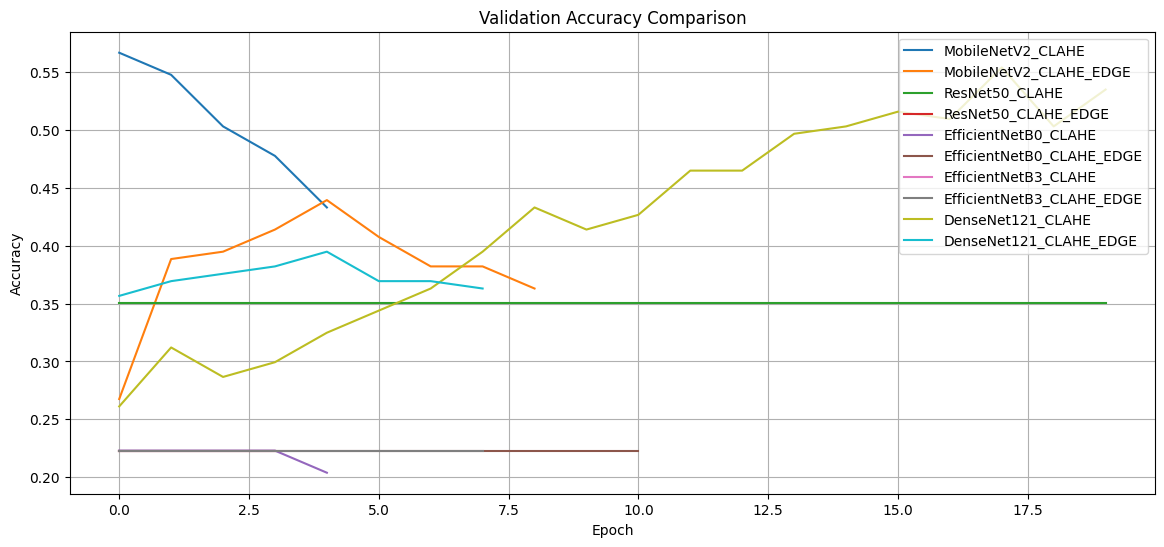

In [ ]:
# ✅ Colab 可运行：CLAHE 与 CLAHE+Edge 输入的 5 模型训练与验证准确率对比
# 支持 MobileNetV2, ResNet18, EfficientNetB0/B3, ShuffleNetV2, DenseNet121

# ✅ 第一步：导入库和挂载 Drive
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

drive.mount('/content/drive')

# ✅ 第二步：数据路径
clahe_dir = "/content/drive/MyDrive/coal/image_classification_Clahe/train_100_Clahe"
clahe_edge_dir = "/content/drive/MyDrive/coal/image_classification_Clahe_Edge/train_100_Clahe_Edge"
val_dir = "/content/drive/MyDrive/coal/image_classification/val"

# ✅ 第三步：数据生成器
img_size = (224, 224)
batch_size = 32

data_gen = ImageDataGenerator(rescale=1./255)

def get_generators(input_dir):
    train_gen = data_gen.flow_from_directory(
        input_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    val_gen = data_gen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    return train_gen, val_gen

# ✅ 第四步：模型构建函数
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, EfficientNetB3, DenseNet121, ResNet50

def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(4, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=output)

# ✅ 第五步：模型列表与训练
model_defs = {
    'MobileNetV2': tf.keras.applications.MobileNetV2,
    'ResNet50': tf.keras.applications.ResNet50,
    'EfficientNetB0': tf.keras.applications.EfficientNetB0,
    'EfficientNetB3': tf.keras.applications.EfficientNetB3,
    'DenseNet121': tf.keras.applications.DenseNet121,
}

history_dict = {}
epochs = 20

for model_name, model_fn in model_defs.items():
    for input_type, input_dir in zip(['CLAHE', 'CLAHE_EDGE'], [clahe_dir, clahe_edge_dir]):
        print(f"\n🔧 Training {model_name} on {input_type}...")
        base = model_fn(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
        for layer in base.layers[:-3]:
            layer.trainable = False
        model = build_model(base)
        model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

        train_gen, val_gen = get_generators(input_dir)
        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=epochs,
            callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
            verbose=1
        )
        history_dict[f"{model_name}_{input_type}"] = history.history['val_accuracy']

# ✅ 第六步：绘图比较
plt.figure(figsize=(14,6))
for name, acc in history_dict.items():
    plt.plot(acc, label=name)
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


## 1.3 Transfer Learning Strategy（Freeze vs Finetune）
## English
This block corresponds to the Colab cell comparing two transfer learning strategies:  
freezing all backbone layers vs fine-tuning only the last few layers.

The goal of this experiment is to understand how each backbone behaves under small-to-medium data sizes.  
When the dataset is limited, fine-tuning tends to amplify noise and destabilize early layers, while freezing keeps the feature extractor consistent.

The results reflect exactly that:  
MobileNetV2_freeze is the most stable across datasets,  
DenseNet121_finetune achieves higher peaks but fluctuates heavily,  
and ResNet50 behaves similarly in both modes.

These findings help us converge on a practical rule:  
**for datasets below ~2000 images, freezing is generally the safer and more consistent choice.**

## 中文
这一部分对应 Colab 中 freeze 与 finetune 两种策略的对比实验。  
目标是评估不同 Backbone 在小样本到中样本规模下的可靠性。

在数据不多的时候，finetune 往往会放大噪声，使前几个卷积层变得不稳定；  
相比之下，freeze 会让 Backbone 当作一个稳定的特征提取器，更容易收敛。

实验结果非常符合预期：  
MobileNetV2_freeze 在各种设置下都最稳定；  
DenseNet121_finetune 虽然峰值高但波动非常大；  
ResNet50 两种模式表现接近。

由此可以总结出一个经验规律：  
**当数据量不足时，freeze 是更稳、更可控的选择。**




📂 Training on Dataset: Original
Found 304 images belonging to 4 classes.
Found 75 images belonging to 4 classes.

🔧 Training MobileNetV2_freeze on Original...
Epoch 1/20
19/19 - 13s - 693ms/step - accuracy: 0.3125 - loss: 1.4344 - val_accuracy: 0.5200 - val_loss: 1.1802
Epoch 2/20
19/19 - 1s - 75ms/step - accuracy: 0.5987 - loss: 1.0330 - val_accuracy: 0.5200 - val_loss: 1.0267
Epoch 3/20
19/19 - 2s - 86ms/step - accuracy: 0.6382 - loss: 0.8815 - val_accuracy: 0.5733 - val_loss: 0.9487
Epoch 4/20
19/19 - 2s - 82ms/step - accuracy: 0.6974 - loss: 0.7785 - val_accuracy: 0.5733 - val_loss: 0.9051
Epoch 5/20
19/19 - 2s - 82ms/step - accuracy: 0.7401 - loss: 0.7128 - val_accuracy: 0.6533 - val_loss: 0.8704
Epoch 6/20
19/19 - 1s - 74ms/step - accuracy: 0.7763 - loss: 0.6565 - val_accuracy: 0.5600 - val_loss: 0.8528
Epoch 7/20
19/19 - 1s - 77ms/step - accuracy: 0.7829 - loss: 0.6116 - val_accuracy: 0.6000 - val_loss: 0.8324
Epoch 8/20
19/19 - 1s - 77ms/step - accuracy: 0.7961 - loss: 0.5818 

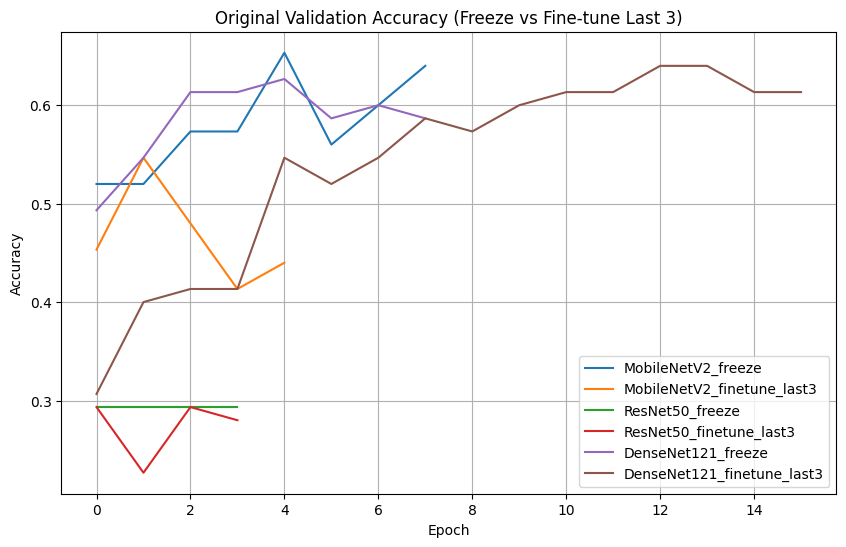


📂 Training on Dataset: CLAHE
Found 304 images belonging to 4 classes.
Found 75 images belonging to 4 classes.

🔧 Training MobileNetV2_freeze on CLAHE...
Epoch 1/20
19/19 - 13s - 692ms/step - accuracy: 0.3257 - loss: 1.3763 - val_accuracy: 0.4400 - val_loss: 1.1679
Epoch 2/20
19/19 - 1s - 69ms/step - accuracy: 0.5822 - loss: 1.0186 - val_accuracy: 0.5867 - val_loss: 1.0003
Epoch 3/20
19/19 - 1s - 69ms/step - accuracy: 0.6776 - loss: 0.8401 - val_accuracy: 0.5733 - val_loss: 0.9192
Epoch 4/20
19/19 - 1s - 74ms/step - accuracy: 0.7500 - loss: 0.7391 - val_accuracy: 0.5867 - val_loss: 0.8757
Epoch 5/20
19/19 - 1s - 70ms/step - accuracy: 0.7566 - loss: 0.6734 - val_accuracy: 0.5733 - val_loss: 0.8632
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.

🔧 Training MobileNetV2_finetune_last3 on CLAHE...
Epoch 1/20
19/19 - 16s - 829ms/step - accuracy: 0.5428 - loss: 1.0817 - val_accuracy: 0.5600 - val_loss: 1.1606
Epoch 2/20
19/19 - 1s - 70ms/step - accuracy: 0.

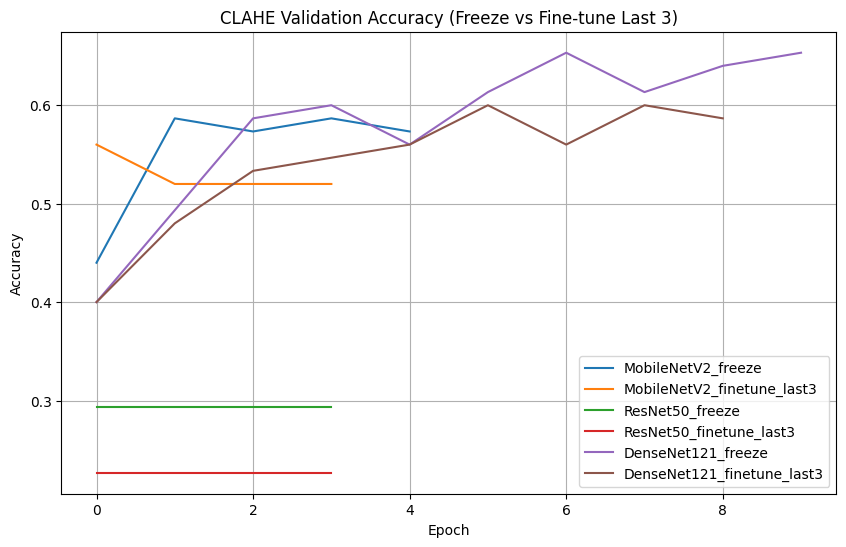

In [ ]:
# ✅ Colab 代码：MobileNetV2、ResNet50(替代18)、DenseNet121
# 训练原始(image_classification)与CLAHE(image_classification_Clahe)两套数据
# 对比「不微调」与「微调最后三层」两种策略

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# ✅ 参数设置
img_size = 224
batch_size = 16
epochs = 20

# ✅ 数据路径
datasets = {
    "Original": "/content/drive/MyDrive/coal/image_classification/train_100",
    "CLAHE": "/content/drive/MyDrive/coal/image_classification_Clahe/train_100_Clahe"
}

# ✅ 模型构建函数
def build_model(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=out)

# ✅ 模型定义
model_defs = {
    "MobileNetV2": tf.keras.applications.MobileNetV2,
    "ResNet50": tf.keras.applications.ResNet50,
    "DenseNet121": tf.keras.applications.DenseNet121
}

# ✅ EarlyStopping 设置
def get_early_stop():
    return EarlyStopping(monitor='val_accuracy', mode='max', patience=3,
                         min_delta=0.002, restore_best_weights=True, verbose=1)

# ✅ 训练函数
def train_model(base, num_classes, trainable_mode):
    if trainable_mode == "freeze":
        for layer in base.layers:
            layer.trainable = False
    elif trainable_mode == "finetune_last3":
        for layer in base.layers[:-3]:
            layer.trainable = False
    model = build_model(base, num_classes)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ✅ 主循环：遍历数据集 + 模型 + 训练策略
for ds_name, ds_path in datasets.items():
    print(f"\n📂 Training on Dataset: {ds_name}")
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_gen = datagen.flow_from_directory(
        ds_path, target_size=(img_size, img_size), batch_size=batch_size,
        class_mode='categorical', subset='training', shuffle=True)
    val_gen = datagen.flow_from_directory(
        ds_path, target_size=(img_size, img_size), batch_size=batch_size,
        class_mode='categorical', subset='validation', shuffle=False)

    histories = {}
    for model_name, constructor in model_defs.items():
        for mode in ["freeze", "finetune_last3"]:
            label = f"{model_name}_{mode}"
            print(f"\n🔧 Training {label} on {ds_name}...")
            base_model = constructor(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
            model = train_model(base_model, train_gen.num_classes, mode)
            hist = model.fit(train_gen, validation_data=val_gen, epochs=epochs,
                             callbacks=[get_early_stop()], verbose=2)
            histories[label] = hist.history['val_accuracy']

    # ✅ 绘图：每个数据集单独一张图
    plt.figure(figsize=(10,6))
    for name, acc in histories.items():
        plt.plot(acc, label=name)
    plt.title(f"{ds_name} Validation Accuracy (Freeze vs Fine-tune Last 3)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()



📂 Running experiments on: Original
Found 2082 images belonging to 4 classes.
Found 157 images belonging to 4 classes.
Found 120 images belonging to 4 classes.

🔧 Training MobileNetV2_freeze on Original...
Epoch 1/20
131/131 - 1334s - 10s/step - accuracy: 0.6105 - loss: 0.9323 - val_accuracy: 0.6943 - val_loss: 0.7286
Epoch 2/20
131/131 - 8s - 58ms/step - accuracy: 0.7354 - loss: 0.6468 - val_accuracy: 0.7006 - val_loss: 0.6611
Epoch 3/20
131/131 - 7s - 56ms/step - accuracy: 0.7531 - loss: 0.5854 - val_accuracy: 0.7006 - val_loss: 0.6630
Epoch 4/20
131/131 - 8s - 60ms/step - accuracy: 0.7863 - loss: 0.5364 - val_accuracy: 0.7006 - val_loss: 0.6594
Epoch 5/20
131/131 - 7s - 57ms/step - accuracy: 0.7882 - loss: 0.5096 - val_accuracy: 0.7006 - val_loss: 0.6447
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.

🔧 Training DenseNet121_freeze on Original...
Epoch 1/20
131/131 - 58s - 441ms/step - accuracy: 0.5418 - loss: 1.0881 - val_accuracy: 0.5860 - val_lo

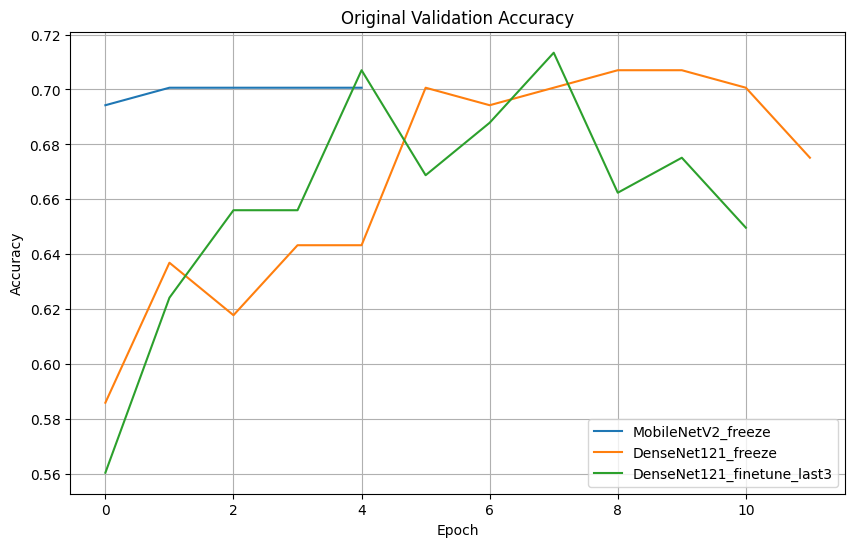

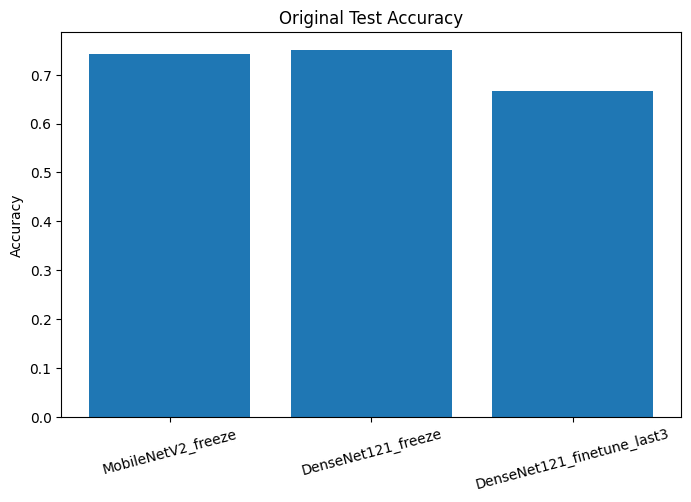


📂 Running experiments on: CLAHE
Found 2082 images belonging to 4 classes.
Found 157 images belonging to 4 classes.
Found 120 images belonging to 4 classes.

🔧 Training MobileNetV2_freeze on CLAHE...
Epoch 1/20
131/131 - 1393s - 11s/step - accuracy: 0.5874 - loss: 0.9402 - val_accuracy: 0.6115 - val_loss: 0.8585
Epoch 2/20
131/131 - 7s - 57ms/step - accuracy: 0.7305 - loss: 0.6715 - val_accuracy: 0.6561 - val_loss: 0.7588
Epoch 3/20
131/131 - 7s - 55ms/step - accuracy: 0.7661 - loss: 0.5978 - val_accuracy: 0.6752 - val_loss: 0.7627
Epoch 4/20
131/131 - 7s - 57ms/step - accuracy: 0.7709 - loss: 0.5522 - val_accuracy: 0.6752 - val_loss: 0.7515
Epoch 5/20
131/131 - 7s - 56ms/step - accuracy: 0.7872 - loss: 0.5277 - val_accuracy: 0.6752 - val_loss: 0.7633
Epoch 6/20
131/131 - 7s - 54ms/step - accuracy: 0.8012 - loss: 0.5001 - val_accuracy: 0.6369 - val_loss: 0.8248
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.

🔧 Training DenseNet121_freeze on CLAHE...


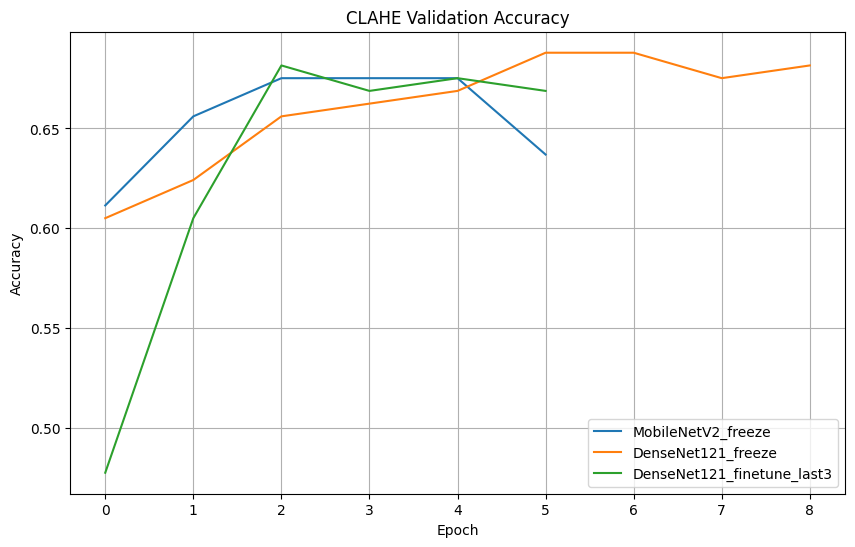

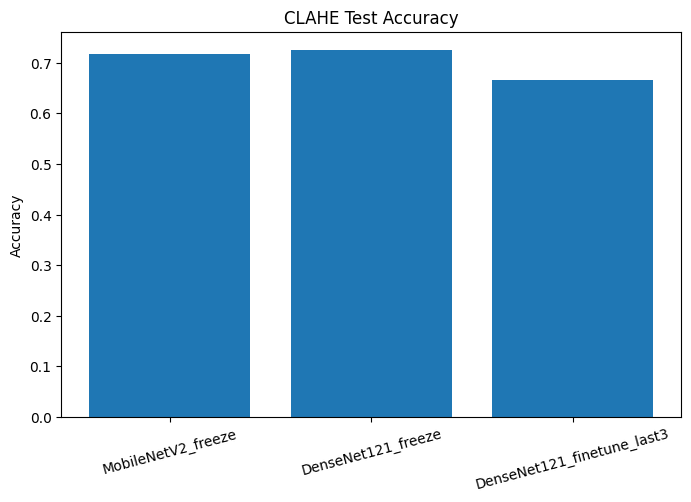

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# ✅ 参数
img_size = 224
batch_size = 16
epochs = 20

# ✅ 数据路径
datasets = {
    "Original": {
        "train": "/content/drive/MyDrive/coal/image_classification/train_500",
        "val": "/content/drive/MyDrive/coal/image_classification/val",
        "test": "/content/drive/MyDrive/coal/image_classification/test",
    },
    "CLAHE": {
        "train": "/content/drive/MyDrive/coal/image_classification_Clahe/train_500_Clahe",
        "val": "/content/drive/MyDrive/coal/image_classification_Clahe/val_Clahe",
        "test": "/content/drive/MyDrive/coal/image_classification_Clahe/test_Clahe",
    }
}

# ✅ 模型构建函数
def build_model(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=out)

# ✅ EarlyStopping
def get_early_stop():
    return EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.002,
                         restore_best_weights=True, verbose=1)

# ✅ 训练函数
def train_model(base, num_classes, trainable_mode):
    if trainable_mode == "freeze":
        for layer in base.layers:
            layer.trainable = False
    elif trainable_mode == "finetune_last3":
        for layer in base.layers[:-3]:
            layer.trainable = False
    model = build_model(base, num_classes)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ✅ 训练 & 测试函数
def run_training(ds_name, ds_paths):
    datagen = ImageDataGenerator(rescale=1./255)
    train_gen = datagen.flow_from_directory(ds_paths["train"], target_size=(img_size, img_size),
                                            batch_size=batch_size, class_mode='categorical')
    val_gen = datagen.flow_from_directory(ds_paths["val"], target_size=(img_size, img_size),
                                          batch_size=batch_size, class_mode='categorical', shuffle=False)
    test_gen = datagen.flow_from_directory(ds_paths["test"], target_size=(img_size, img_size),
                                           batch_size=batch_size, class_mode='categorical', shuffle=False)

    # ✅ 需要训练的模型
    configs = [
        ("MobileNetV2_freeze", tf.keras.applications.MobileNetV2, "freeze"),
        ("DenseNet121_freeze", tf.keras.applications.DenseNet121, "freeze"),
        ("DenseNet121_finetune_last3", tf.keras.applications.DenseNet121, "finetune_last3"),
    ]

    histories, test_accs = {}, {}

    for label, constructor, mode in configs:
        print(f"\n🔧 Training {label} on {ds_name}...")
        base_model = constructor(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
        model = train_model(base_model, train_gen.num_classes, mode)
        hist = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[get_early_stop()], verbose=2)
        histories[label] = hist.history['val_accuracy']

        # ✅ 测试准确率
        loss, acc = model.evaluate(test_gen, verbose=0)
        test_accs[label] = acc

    # ✅ 绘制 val_accuracy
    plt.figure(figsize=(10,6))
    for name, acc in histories.items():
        plt.plot(acc, label=name)
    plt.title(f"{ds_name} Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ✅ 绘制 test accuracy 条形图
    plt.figure(figsize=(8,5))
    plt.bar(test_accs.keys(), test_accs.values())
    plt.title(f"{ds_name} Test Accuracy")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=15)
    plt.show()

# ✅ 主程序：原始 & CLAHE
for ds, paths in datasets.items():
    print(f"\n📂 Running experiments on: {ds}")
    run_training(ds, paths)


## 1.4 Scaling Up（500 → 5000）& Final Model Choice
## English
This block summarizes the Colab cells where the dataset is expanded from 500 to 5000 images.  
The purpose is not only to improve accuracy but to observe how each candidate model scales as data increases.

With 500 images, we start to see clearer differences:  
MobileNetV2_freeze stays stable and efficient,  
DenseNet121_finetune reaches high accuracy but is too heavy for real-time use,  
and CLAHE's benefit becomes smaller as lighting variance is reduced by data volume.

The 5000-sample experiment confirms the trend.  
MobileNetV2_freeze reaches solid validation and test accuracy while maintaining low latency and small model size.  
This makes it the most suitable model for downstream integration with YOLO detection and Flask deployment.

The final exported model is:  
`mobilenetv2_freeze_model.h5`

## 中文
这一部分对应 Colab 中将规模从 500 扩展到 5000 的训练实验。  
这一步的重点不只是提升准确率，更重要的是观察模型随数据增长的稳定性和扩展能力。

在 500 数据规模下，差异变得明显：  
MobileNetV2_freeze 稳定性最好；  
DenseNet121_finetune 虽然精度高但太重，不适合实时部署；  
随着数据增多，CLAHE 的优势相对变弱，因为光照差异开始被数据量平均掉。

在 5000 数据规模下，趋势完全明确：  
MobileNetV2_freeze 准确率稳健、模型轻量、推理速度快，非常适合后续与 YOLO 结合并上线到 Flask 服务。

最终输出的模型为：  
`mobilenetv2_freeze_model.h5`



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Found 5552 images belonging to 4 classes.
Found 157 images belonging to 4 classes.
Found 120 images belonging to 4 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
347/347 - 1120s - 3s/step - accuracy: 0.6614 - loss: 0.8176 - val_accuracy: 0.6688 - val_loss: 0.6659
Epoch 2/20
347/347 - 18s - 52ms/step - accuracy: 0.7363 - loss: 0.6320 - val_accuracy: 0.7070 - val_loss: 0.6300
Epoch 3/20
347/347 - 18s - 52ms/step - accuracy: 0.7561 - loss: 0.5833 - val_accuracy: 0.7134 - val_loss: 0.6554
Epoch 4/20
347/347 - 18s - 51ms/step - accuracy: 0.7639 - loss: 0.5534 - val_accuracy: 0.7070 - val_loss: 0.6463
Epoch 5/20
347/347 - 18s - 51ms/step - accuracy: 0.7725 - loss: 0.5326 - val_accuracy: 0.7389 - val_loss: 0.6582
Epoch 6/20
347/347 - 18s - 51ms/step - accuracy: 0.7824 - loss: 0.5119 - val_accuracy: 0.7452 - val_loss: 0.6342
Epoch 7/20
347/347 - 17s - 50ms/step - accuracy: 0.7986 - loss: 0.4919 - val_accuracy: 0.7134 - val_loss: 0.6559
Epoch 8/20
347/347 - 17s - 50ms/step - accuracy: 0.8021 - loss: 0.4787 - val_accuracy: 0.7325 - val_loss: 0.6262
Epoch 9/20
347/347 - 17s - 50ms/step - accuracy: 0.8084 - loss: 0.4642 - val_accuracy: 0.7197 - 


✅ Test Accuracy: 0.7250


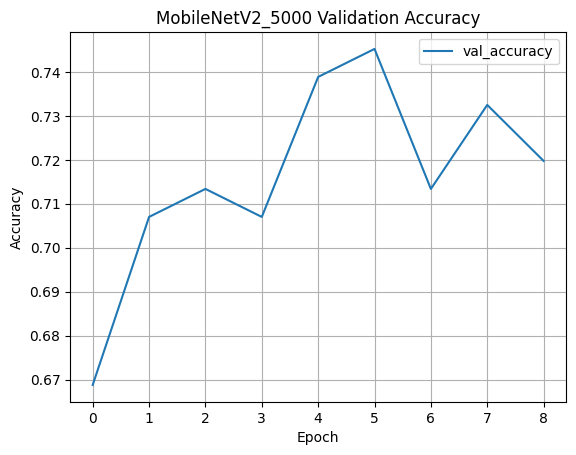

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# ✅ 参数设置
img_size = 224
batch_size = 16
epochs = 20

# ✅ 数据路径（更大的训练集）
ds_name = "MobileNetV2_5000"
ds_paths = {
    "train": "/content/drive/MyDrive/coal/image_classification/train_5000",
    "val": "/content/drive/MyDrive/coal/image_classification/val",
    "test": "/content/drive/MyDrive/coal/image_classification/test"
}

# ✅ 数据生成器
datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_directory(ds_paths["train"], target_size=(img_size, img_size),
                                        batch_size=batch_size, class_mode='categorical')
val_gen = datagen.flow_from_directory(ds_paths["val"], target_size=(img_size, img_size),
                                      batch_size=batch_size, class_mode='categorical', shuffle=False)
test_gen = datagen.flow_from_directory(ds_paths["test"], target_size=(img_size, img_size),
                                       batch_size=batch_size, class_mode='categorical', shuffle=False)

# ✅ 构建模型
def build_model(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=out)

# ✅ EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.002,
                           restore_best_weights=True, verbose=1)

# ✅ 初始化 MobileNetV2 并冻结全部层
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False,
                                               input_shape=(img_size, img_size, 3))
for layer in base_model.layers:
    layer.trainable = False

# ✅ 编译和训练
model = build_model(base_model, train_gen.num_classes)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[early_stop], verbose=2)

# ✅ 测试集评估
loss, acc = model.evaluate(test_gen, verbose=0)
print(f"\n✅ Test Accuracy: {acc:.4f}")

# ✅ 保存模型
model.save("/content/drive/MyDrive/coal/mobilenetv2_freeze_model.h5")

# ✅ 可视化 val_accuracy
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title(f"{ds_name} Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


# 2. YOLO Detection Pipeline（YOLOv5 + YOLOv8）
## English
This section corresponds to all Colab cells that prepare and train both YOLOv5 and YOLOv8 models.  
The purpose of this part is straightforward: **convert VOC-style annotations into YOLO format, build clean train/val/test splits, and train lightweight detectors that can reliably locate coal regions on conveyor-belt images.**

The pipeline begins with YOLOv5. After installing the repo, we convert all VOC XML labels into YOLO TXT format. Every bounding box is normalized (x_center, y_center, width, height) so the detector learns scale-invariant coordinates. Once labels are ready, we create an 80/10/10 split and copy images + labels into YOLOv5’s expected folder structure. A simple `coal.yaml` file defines the dataset paths and the three detection classes (“coal”, “gangue”, “unknown”). Training is done with the standard `yolov5s.pt` checkpoint, which is small enough to train quickly while still giving solid detection performance. The resulting `best.pt` is exported for later inference.

We repeat a similar process for YOLOv8 but use a cleaner dataset structure and a single-class setting (“target”). The logic is identical:  
split → convert XML → write YOLO TXT → generate data.yaml → train.  
YOLOv8n is used here because it provides fast training and low latency, making it suitable for later integration into the Flask inference pipeline.

Together, these cells form a complete detection workflow: data conversion, dataset organization, YAML definition, and model training. The final weights from YOLOv5 or YOLOv8 can be plugged directly into the downstream classifier pipeline to crop ROIs for MobileNetV2.

## 中文
本节对应所有 YOLOv5 与 YOLOv8 的 Colab cell。  
整体目标很明确：**把 VOC 标注数据转换成 YOLO 格式，构建标准化的 train/val/test 数据集，并训练轻量级的 YOLO 检测模型，用于定位传送带上的煤块区域。**

流程首先从 YOLOv5 开始。安装仓库后，将所有 VOC XML 文件转换为 YOLO TXT 格式，每个框都被归一化成 (x_center, y_center, width, height)，让模型具备尺度不变性。接着建立 80/10/10 的数据划分，并将图片与标签按 YOLOv5 的目录要求拷贝。`coal.yaml` 中定义数据路径与三个类别（“coal”、“gangue”、“unknown”）。随后以 `yolov5s.pt` 作为初始权重进行训练，该模型体积小、训练快，适合快速验证。最终的 `best.pt` 会用于后续推理。

YOLOv8 的流程类似，但数据结构更干净，同时采用 **单类目标**（“target”）。步骤与 YOLOv5 基本一致：  
先划分数据 → 再将 XML 转成 YOLO TXT → 写 data.yaml → 训练 YOLOv8n。  
YOLOv8n（nano）版本速度最快、延迟低，特别适合之后与 Flask API 组合做实时推理。

整体而言，这部分 Cell 构成了完整的检测管线：格式转换、数据组织、yaml 配置、模型训练。YOLOv5 或 YOLOv8 训练出的权重都可以直接用于下游 MobileNetV2 分类阶段，用于裁剪 ROI 区域进行煤质判别。



In [ ]:
# ✅ STEP 1: 安装 YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -r requirements.txt

# ✅ STEP 2: VOC(XML) ➜ YOLO(TXT)
import os, xml.etree.ElementTree as ET, shutil, random
from pathlib import Path

# 🔧 修改成你自己的路径（VOC 格式输入）
image_dir = '/content/drive/MyDrive/coal/YOLO/img'
xml_dir = '/content/drive/MyDrive/coal/YOLO/annotation'
yolo_labels_dir = '/content/drive/MyDrive/coal/YOLO/labels'
os.makedirs(yolo_labels_dir, exist_ok=True)
classes = ['coal', 'gangue', 'unknown']

def convert(size, box):
    dw, dh = 1. / size[0], 1. / size[1]
    x, y = (box[0]+box[2])/2.0, (box[1]+box[3])/2.0
    w, h = box[2]-box[0], box[3]-box[1]
    return x*dw, y*dh, w*dw, h*dh

for file in os.listdir(xml_dir):
    if not file.endswith('.xml'): continue
    tree = ET.parse(os.path.join(xml_dir, file))
    root = tree.getroot()
    size = root.find('size')
    w, h = int(size.find('width').text), int(size.find('height').text)
    with open(os.path.join(yolo_labels_dir, file.replace('.xml', '.txt')), 'w') as out_file:
        for obj in root.iter('object'):
            cls = obj.find('name').text
            if cls not in classes: continue
            cls_id = classes.index(cls)
            xmlbox = obj.find('bndbox')
            b = [int(xmlbox.find(tag).text) for tag in ['xmin','ymin','xmax','ymax']]
            bb = convert((w, h), b)
            out_file.write(f"{cls_id} {' '.join(map(str, bb))}\n")

# ✅ STEP 3: 划分 train/val/test 数据集
images = list(Path(image_dir).glob('*.jpg'))
random.shuffle(images)
split_idx = [int(len(images)*x) for x in [0.8, 0.9]]
splits = {'train': images[:split_idx[0]], 'val': images[split_idx[0]:split_idx[1]], 'test': images[split_idx[1]:]}
base_out = Path('/content/drive/MyDrive/coal/YOLO/dataset')
for split in splits:
    (base_out/split/'images').mkdir(parents=True, exist_ok=True)
    (base_out/split/'labels').mkdir(parents=True, exist_ok=True)
    for img_path in splits[split]:
        label_path = Path(yolo_labels_dir)/img_path.with_suffix('.txt').name
        if label_path.exists():
            shutil.copy(img_path, base_out/split/'images'/img_path.name)
            shutil.copy(label_path, base_out/split/'labels'/label_path.name)

# ✅ STEP 4: 创建 data.yaml 配置
yaml_str = """
train: /content/drive/MyDrive/coal/YOLO/dataset/train/images
val: /content/drive/MyDrive/coal/YOLO/dataset/val/images
test: /content/drive/MyDrive/coal/YOLO/dataset/test/images

nc: 3
names: ['coal', 'gangue', 'unknown']
"""
with open("coal.yaml", "w") as f:
    f.write(yaml_str)

# ✅ STEP 5: 开始训练 YOLOv5 模型
!python train.py --img 640 --batch 16 --epochs 50 --data coal.yaml --weights yolov5s.pt --cache

# ✅ STEP 6: 复制 best.pt 到你的 Google Drive
!cp runs/train/exp/weights/best.pt /content/drive/MyDrive/coal/models/yolov5_coal_best.pt


Cloning into 'yolov5'...
remote: Enumerating objects: 17564, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 17564 (delta 33), reused 7 (delta 7), pack-reused 17510 (from 4)
Receiving objects: 100% (17564/17564), 16.65 MiB | 17.16 MiB/s, done.
Resolving deltas: 100% (12035/12035), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-09-03 21:11:09.452911: E external/local_xla/xla/stream_executor/cuda/cuda_f

In [ ]:
# Step 1: 挂载 Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Step 2: 设置路径
import os
from pathlib import Path

base_dir = Path("/content/drive/MyDrive/coal/YOLO_V8")
img_dir = base_dir / "img"
anno_dir = base_dir / "annotation"
output_dir = base_dir / "yolo_dataset"

output_img = output_dir / "images"
output_anno = output_dir / "labels"

for subfolder in ["train", "val", "test"]:
    os.makedirs(output_img / subfolder, exist_ok=True)
    os.makedirs(output_anno / subfolder, exist_ok=True)


In [ ]:
# Step 3: 划分数据集
from sklearn.model_selection import train_test_split
import shutil

all_imgs = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
train_imgs, test_imgs = train_test_split(all_imgs, test_size=0.2, random_state=42)
train_imgs, val_imgs = train_test_split(train_imgs, test_size=0.2, random_state=42)

split_dict = {'train': train_imgs, 'val': val_imgs, 'test': test_imgs}


In [ ]:
# Step 4: 拷贝图片和 XML → TXT 转换
import xml.etree.ElementTree as ET

def convert_voc_to_yolo(xml_path, img_width, img_height):
    root = ET.parse(xml_path).getroot()
    yolo_lines = []

    for obj in root.findall('object'):
        bnd = obj.find("bndbox")
        xmin = int(bnd.find("xmin").text)
        ymin = int(bnd.find("ymin").text)
        xmax = int(bnd.find("xmax").text)
        ymax = int(bnd.find("ymax").text)

        # 转为相对坐标
        x_center = (xmin + xmax) / 2 / img_width
        y_center = (ymin + ymax) / 2 / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height

        # 类别固定为 0（任意目标）
        yolo_lines.append(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    return yolo_lines


In [ ]:
from PIL import Image

for split, img_list in split_dict.items():
    for img_name in img_list:
        # 拷贝图像
        src_img_path = img_dir / img_name
        dst_img_path = output_img / split / img_name
        shutil.copy(src_img_path, dst_img_path)

        # 转换标注
        xml_path = anno_dir / img_name.replace(".jpg", ".xml")
        dst_txt_path = output_anno / split / img_name.replace(".jpg", ".txt")

        if not xml_path.exists():
            print(f"Warning: {xml_path} not found!")
            continue

        with Image.open(src_img_path) as img:
            w, h = img.size

        yolo_annos = convert_voc_to_yolo(xml_path, w, h)
        with open(dst_txt_path, "w") as f:
            f.write("\n".join(yolo_annos))


In [ ]:
# Step 5: 创建 data.yaml
data_yaml = f"""
path: {output_dir}
train: images/train
val: images/val
test: images/test

names:
  0: target
"""

with open(base_dir / "data.yaml", "w") as f:
    f.write(data_yaml.strip())


In [ ]:
# Step 6: 安装 ultralytics 并训练 YOLOv8
!pip install -q ultralytics
from ultralytics import YOLO

model = YOLO("yolov8n.yaml")  # 使用 nano 版本（最快）
model.train(
    data=str(base_dir / "data.yaml"),
    epochs=20,
    imgsz=640,
    batch=16,
    project=str(base_dir / "runs"),
    name="exp",
    exist_ok=True
)


Ultralytics 8.3.192 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/coal/YOLO_V8/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plot

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7be8bcf0d220>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# 3. End-to-End Inference Service (Flask + YOLO + MobileNetV2)
## English
This part describes how we wrap the whole pipeline into a single, stateless HTTP service using Flask, with YOLO as the detector and MobileNetV2 as the quality classifier.

At startup, the Flask app loads all heavy assets once into memory:
- YOLOv5/YOLOv8 weights for **object detection** (coal region localization)  
- The frozen **MobileNetV2** classifier (`mobilenetv2_freeze_model.h5`) for coal quality prediction  

We then expose a `POST /predict` endpoint. A typical request sends one conveyor-belt image (e.g., multipart/form-data or base64). The handler does three things in sequence:

1. **Detection**  
   Pass the image through YOLO, filter out low-confidence boxes, and get bounding boxes for all coal-like regions on the belt.

2. **Cropping + Preprocessing**  
   For each box, crop the ROI, resize to 224×224, apply the same normalization as in training (rescale, optional CLAHE), and stack them into a small batch.

3. **Classification & Aggregation**  
   Run the ROI batch through MobileNetV2 to obtain class probabilities for each patch. Then aggregate these patch-level predictions into interpretable metrics, such as:
   - per-patch quality labels (high / acceptable / poor)  
   - overall quality distribution for the whole image or batch  
   - optional confidence scores

The response is a JSON object, e.g.:
- list of bounding boxes + class labels  
- overall coal quality summary for the truck / belt segment  

To ensure latency stays under ~1s, the app:
- loads models only once at startup (not per request)  
- limits input resolution and max number of ROIs per request  
- runs on a small EC2 instance or edge server, optionally behind gunicorn with multiple workers

From the outside, it is just a REST API: send an image, get structured quality results back. Internally, it is the full YOLO + MobileNetV2 pipeline we built, wrapped into a clean, production-style service.

## 中文
这一部分介绍如何用 Flask 把整个流程封装成一个 **端到端在线推理服务**，前半段用 YOLO 做检测，后半段用 MobileNetV2 做煤质分类。

服务启动时，Flask 进程会一次性把所有大模型加载到内存中：
- YOLOv5 / YOLOv8 权重（负责识别传送带上的煤块位置）  
- 训练好的 **MobileNetV2 分类模型**（`mobilenetv2_freeze_model.h5`，负责判断煤质等级）  

然后暴露一个 `POST /predict` 接口。客户端上传一张传送带图像（比如表单图片或 base64），后端按顺序执行三步：

1. **目标检测**  
   用 YOLO 对整张图做预测，过滤掉低置信度框，得到当前画面中的所有煤块区域。

2. **裁剪 + 预处理**  
   对每个检测框，从原图裁剪 ROI，统一 resize 到 224×224，并做与训练阶段一致的预处理（归一化、可选 CLAHE），打包成一个小 batch。

3. **分类与汇总**  
   将 ROI batch 输入 MobileNetV2，得到每个小块的煤质类别概率。  
   再将这些 patch 级别的结果聚合成更易用的指标，比如：
   - 每个框对应的煤质等级（高 / 可接受 / 差）  
   - 整车或整段皮带的大致合格率 / 质量分布  
   - 对应的置信度信息  

接口返回的是一个 JSON，例如：
- 每个 bounding box 的位置 + 分类标签  
- 当前这车煤整体质量的汇总结果  

为了把延迟控制在约 1 秒内，服务会：
- 只在启动时加载模型，而不是每次请求都重新加载  
- 限制输入图片分辨率和每次请求的 ROI 数量  
- 在小规格 EC2 或边缘服务器上运行，通常配合 gunicorn 多 worker 提升并发能力  

对外来看，这只是一个简单的 REST API：  
“上传图片 → 返回结构化的煤质检测结果”；  
对内，它封装的是我们完整的 YOLO + MobileNetV2 推理链路，并以工程可落地的方式对外提供服务。



In [ ]:
"""
app.py  –  End-to-End Inference Service (Flask + YOLO + MobileNetV2)

English:
    - Loads YOLO (detection) and MobileNetV2 (classification) once at startup.
    - Exposes two endpoints:
        * GET /health      – quick health check
        * POST /predict    – accepts an image, returns JSON with boxes + quality labels

中文：
    - 服务启动时一次性加载 YOLO（检测）和 MobileNetV2（分类）模型
    - 提供两个接口：
        * GET /health      – 健康检查
        * POST /predict    – 上传图片，返回框位置 + 煤质分类结果（JSON）
"""

import io
import os
import time
import numpy as np
from typing import List, Dict

from flask import Flask, request, jsonify
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import load_model

from ultralytics import YOLO

# -----------------------------
# Config
# -----------------------------
YOLO_WEIGHTS_PATH = "/content/drive/MyDrive/coal/YOLO_V8/train_run/weights/best.pt"
CLASSIFIER_WEIGHTS_PATH = "/content/drive/MyDrive/coal/mobilenetv2_freeze_model.h5"

IMG_SIZE = 224
MIN_CONF = 0.3          # minimum YOLO confidence to keep a box
MAX_ROIS = 32           # max number of cropped patches per request

QUALITY_LABELS = ["high", "acceptable", "poor", "background"]  # index 0..3


# -----------------------------
# Model Loading (run once)
# -----------------------------
app = Flask(__name__)

print("[INFO] Loading YOLO model...")
yolo_model = YOLO(YOLO_WEIGHTS_PATH)

print("[INFO] Loading MobileNetV2 classifier...")
classifier_model = load_model(CLASSIFIER_WEIGHTS_PATH)

print("[INFO] Models loaded. Ready to serve requests.")


# -----------------------------
# Utility Functions
# -----------------------------
def read_image_from_request(req) -> Image.Image:
    """
    Read image from Flask request (form-data: 'image') and return a PIL Image.
    请求中读取图片（表单字段名为 'image'），返回 PIL Image。
    """
    if 'image' not in req.files:
        raise ValueError("No file part named 'image' in the request.")
    file = req.files['image']
    if file.filename == '':
        raise ValueError("Empty filename.")
    img_bytes = file.read()
    return Image.open(io.BytesIO(img_bytes)).convert("RGB")


def run_yolo_detection(pil_img: Image.Image):
    """
    Run YOLO detection on a PIL image and return boxes, confs, classes.
    在 PIL 图上跑 YOLO，返回框坐标、置信度和类别索引。
    """
    results = yolo_model(pil_img, verbose=False)
    if len(results) == 0:
        return [], [], []

    res = results[0]
    if res.boxes is None or res.boxes.xyxy is None:
        return [], [], []

    xyxy = res.boxes.xyxy.cpu().numpy()
    conf = res.boxes.conf.cpu().numpy()
    cls = res.boxes.cls.cpu().numpy().astype(int)
    return xyxy, conf, cls


def crop_and_preprocess_rois(pil_img: Image.Image, boxes: np.ndarray) -> np.ndarray:
    """
    Crop ROIs from PIL image using YOLO boxes and preprocess for MobileNetV2.
    根据 YOLO 检测框裁剪 ROI，并预处理成 MobileNetV2 输入格式。
    """
    rois = []
    w, h = pil_img.size

    for i, (x1, y1, x2, y2) in enumerate(boxes):
        if i >= MAX_ROIS:
            break
        # clamp to image boundary
        x1_clamp = max(0, int(x1))
        y1_clamp = max(0, int(y1))
        x2_clamp = min(w, int(x2))
        y2_clamp = min(h, int(y2))
        if x2_clamp <= x1_clamp or y2_clamp <= y1_clamp:
            continue

        roi = pil_img.crop((x1_clamp, y1_clamp, x2_clamp, y2_clamp))
        roi = roi.resize((IMG_SIZE, IMG_SIZE))
        roi_arr = np.array(roi).astype("float32") / 255.0  # same normalization as training
        rois.append(roi_arr)

    if not rois:
        return np.zeros((0, IMG_SIZE, IMG_SIZE, 3), dtype="float32")
    return np.stack(rois, axis=0)


def classify_rois(roi_batch: np.ndarray) -> np.ndarray:
    """
    Run MobileNetV2 classifier on ROI batch, return softmax probabilities.
    对 ROI batch 进行分类，返回 softmax 概率矩阵。
    """
    if roi_batch.shape[0] == 0:
        return np.zeros((0, len(QUALITY_LABELS)), dtype="float32")
    probs = classifier_model.predict(roi_batch, verbose=0)
    return probs


def aggregate_quality(probs: np.ndarray) -> Dict:
    """
    Aggregate patch-level predictions into a summary (count per label).
    将每个 patch 的分类结果聚合成整体质量统计。
    """
    if probs.shape[0] == 0:
        return {"total_patches": 0, "distribution": {}, "majority_label": None}

    pred_idx = np.argmax(probs, axis=1)
    counts = {label: 0 for label in QUALITY_LABELS}
    for idx in pred_idx:
        label = QUALITY_LABELS[idx]
        counts[label] += 1

    total = int(probs.shape[0])
    # compute ratio
    dist = {
        label: {
            "count": int(cnt),
            "ratio": float(cnt) / total if total > 0 else 0.0
        }
        for label, cnt in counts.items()
    }
    # majority label
    majority_label = max(counts.items(), key=lambda x: x[1])[0]

    return {
        "total_patches": total,
        "distribution": dist,
        "majority_label": majority_label
    }


# -----------------------------
# Flask Endpoints
# -----------------------------
@app.route("/health", methods=["GET"])
def health():
    """
    Simple health check endpoint.
    健康检查接口。
    """
    return jsonify({"status": "ok"}), 200


@app.route("/predict", methods=["POST"])
def predict():
    """
    Main inference endpoint.
    - Input: image file (form-data, key='image')
    - Output: JSON with YOLO boxes + per-ROI quality + aggregated quality summary

    主推理接口：
    - 输入：表单上传的图片（字段名 'image'）
    - 输出：包含检测框、每个 ROI 煤质等级以及整体统计的 JSON。
    """
    start_time = time.time()
    try:
        pil_img = read_image_from_request(request)
    except Exception as e:
        return jsonify({"error": str(e)}), 400

    # 1. YOLO detection
    boxes, confs, yolo_classes = run_yolo_detection(pil_img)
    if not boxes:
        elapsed = time.time() - start_time
        return jsonify({
            "num_detections": 0,
            "boxes": [],
            "summary": {
                "total_patches": 0,
                "distribution": {},
                "majority_label": None
            },
            "latency_sec": elapsed
        }), 200

    # filter by confidence
    boxes = np.array(boxes)
    confs = np.array(confs)
    yolo_classes = np.array(yolo_classes)

    keep_mask = confs >= MIN_CONF
    boxes = boxes[keep_mask]
    confs = confs[keep_mask]
    yolo_classes = yolo_classes[keep_mask]

    if boxes.shape[0] == 0:
        elapsed = time.time() - start_time
        return jsonify({
            "num_detections": 0,
            "boxes": [],
            "summary": {
                "total_patches": 0,
                "distribution": {},
                "majority_label": None
            },
            "latency_sec": elapsed
        }), 200

    # 2. Crop + preprocess ROIs
    roi_batch = crop_and_preprocess_rois(pil_img, boxes)

    # 3. Classification
    probs = classify_rois(roi_batch)
    summary = aggregate_quality(probs)

    # per-ROI details
    roi_results: List[Dict] = []
    for i in range(probs.shape[0]):
        q_idx = int(np.argmax(probs[i]))
        q_label = QUALITY_LABELS[q_idx]
        q_conf = float(np.max(probs[i]))
        x1, y1, x2, y2 = boxes[i].tolist()
        roi_results.append({
            "bbox": [float(x1), float(y1), float(x2), float(y2)],
            "yolo_cls": int(yolo_classes[i]),
            "yolo_conf": float(confs[i]),
            "quality_label": q_label,
            "quality_prob": q_conf
        })

    elapsed = time.time() - start_time
    resp = {
        "num_detections": len(roi_results),
        "boxes": roi_results,
        "summary": summary,
        "latency_sec": elapsed
    }
    return jsonify(resp), 200


if __name__ == "__main__":
    # For local testing / debug. In production, run with gunicorn:
    # gunicorn -w 2 -b 0.0.0.0:8000 app:app
    app.run(host="0.0.0.0", port=8000, debug=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 200/200 [01:14<00:00,  2.68it/s]


✅ 图像数：200，标注数：200，有效样本数：200
Ultralytics 8.3.192 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/coal/YOLO_V8/V8_train1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_run, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mas